# Amortized Inference for NLME Model - Single Cell Posterior
**(model from Fröhlich et. al. 2018)**

In [1]:
# load necessary packages
import numpy as np
import pandas as pd
from numba import njit

from functools import partial
from typing import Union

# for plots
import matplotlib.pyplot as plt
from tqdm import tqdm

# sampling posterior
from pypesto import sample, optimize, visualize, FD, Objective, Problem, store

In [2]:
# specify which model to use
model_name = ['fröhlich-simple', 'fröhlich-detailed', 'pharmacokinetic_model', 'clairon_small_model'][3]
network_idx = 0
load_best_network = False

## Load individual model


In [3]:
if model_name == 'fröhlich-simple':
    from models.froehlich_model_simple import FroehlichModelSimple, batch_simulator
    model = FroehlichModelSimple(network_idx=network_idx, load_best=load_best_network)
    
elif model_name == 'fröhlich-detailed':
    from models.froehlich_model_detailed import FroehlichModelDetailed, batch_simulator
    model = FroehlichModelDetailed(network_idx=network_idx, load_best=load_best_network)

elif model_name == 'pharmacokinetic_model':
    from models.pharmacokinetic_model import PharmacokineticModel, batch_simulator, convert_bf_to_observables
    model = PharmacokineticModel(network_idx=network_idx, load_best=load_best_network)
    
elif model_name == 'clairon_small_model':
    from models.clairon_small_model import ClaironSmallModel, batch_simulator, convert_bf_to_observables
    model = ClaironSmallModel(network_idx=network_idx, load_best=load_best_network)
else:
    raise NotImplementedError('model not implemented')

# load network
trainer = model.build_trainer('networks/' + model.network_name)

/Users/jonas.arruda/miniconda/envs/amortizedNLME/lib/python3.10/site-packages/bayesflow/trainers.py:27: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
  Activating project at `~/PyCharm Projects/Amortized-NLME/models/SimulatorSmallClairon`
[ Info: Precompiling SciMLBasePythonCallExt [2797fd30-2078-5027-980c-4c2c8a19c528]
ERROR: LoadError: ArgumentError: Package PythonCall [6099a3de-0909-46bc-b1f4-468b9a2dfc0d] is required but does not seem to be installed:
 - Run `Pkg.instantiate()` to install all recorded dependencies.

Stacktrace:
 [1] _require(pkg::Base.PkgId, env::String)
   @ Base ./loading.jl:1774
 [2] _require_prelocked(uuidkey::Base.PkgId, env::String)
   @ Base ./loading.jl:1660
 [3] macro expansion
   @ ./loading.jl:1648 [inlined]
 [4] macro expansion
   @ ./lock.jl:267 [inlined]
 [5] require(into::Module, mod::Symbol)
   @ Base ./loading.jl:

using 2 layers of MultiConv1D, a  LSTM with 8 units and a dense layer with output dimension 14 as summary network
using a 7-layer cINN as inference network with 2 layers of design affine
Using normal prior
prior mean: [ 1.38629436  2.48490665  2.89037176  1.09861229 -4.60517019 -2.30258509
 -2.30258509]
prior covariance diagonal: [6 6 6 6 6 6 6]
Using the model ClaironModel


INFO:root:Performing 2 pilot runs with the ClaironModel model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 7)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 7, 3)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.
INFO:root:Initialized empty loss history.
INFO:root:Initialized networks from scratch.
INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


Model: "amortized_posterior"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 invertible_network (Inverti  multiple                 541478    
 bleNetwork)                                                     
                                                                 
 sequence_network (SequenceN  multiple                 9086      
 etwork)                                                         
                                                                 
Total params: 550,564
Trainable params: 550,466
Non-trainable params: 98
_________________________________________________________________
None


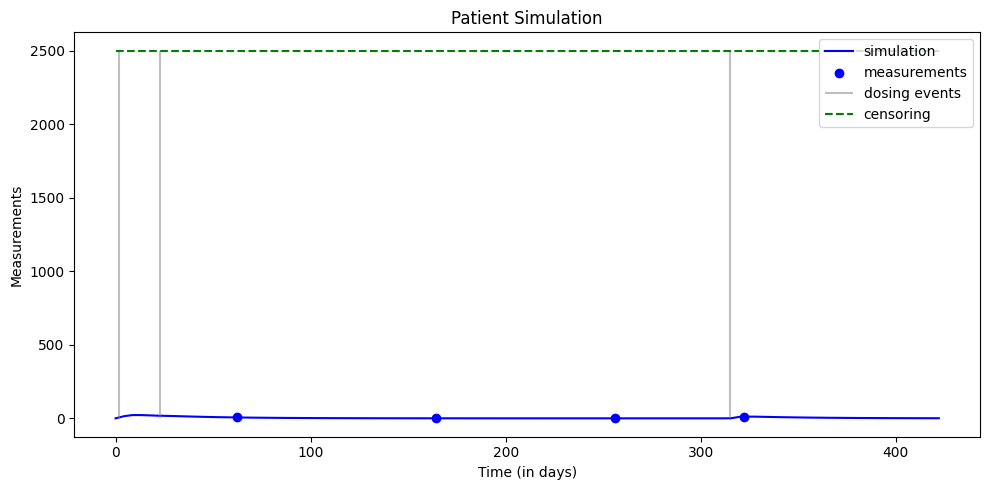

In [4]:
model.plot_example()

## Load Data

In [5]:
# load synthetic data for specific model
load_synthetic = False
obs_data = model.load_data(synthetic=load_synthetic)

# chose 10 random individuals/cells
np.random.seed(42)
individual_ids = np.random.randint(0, len(obs_data), size=10)  # obs_data can be list or numpy array
obs_data = [obs_data[i] for i in individual_ids]
    

if load_synthetic:
    # for these model parameters are known
    if model_name == 'fröhlich-sde':
        cell_param_log = pd.read_csv(f'data/synthetic/synthetic_individual_cell_params_sde_model.csv',
                                     index_col=0, header=0)
    elif model_name == 'fröhlich-detailed':
        cell_param_log = pd.read_csv(f'data/synthetic/synthetic_individual_cell_params_detailed_model.csv',
                                     index_col=0, header=0)
    else:
        cell_param_log = pd.read_csv(f'data/synthetic/synthetic_individual_cell_params.csv',
                                     index_col=0, header=0)

## Examine Posterior for a Single Individual/Cell

In [6]:
# use observations to get a first look at the posterior
n_bayesflow_samples = 100
obs_data_posterior_samples = model.draw_posterior_samples(data=obs_data, n_samples=n_bayesflow_samples)

100%|██████████| 10/10 [00:02<00:00,  4.08it/s]


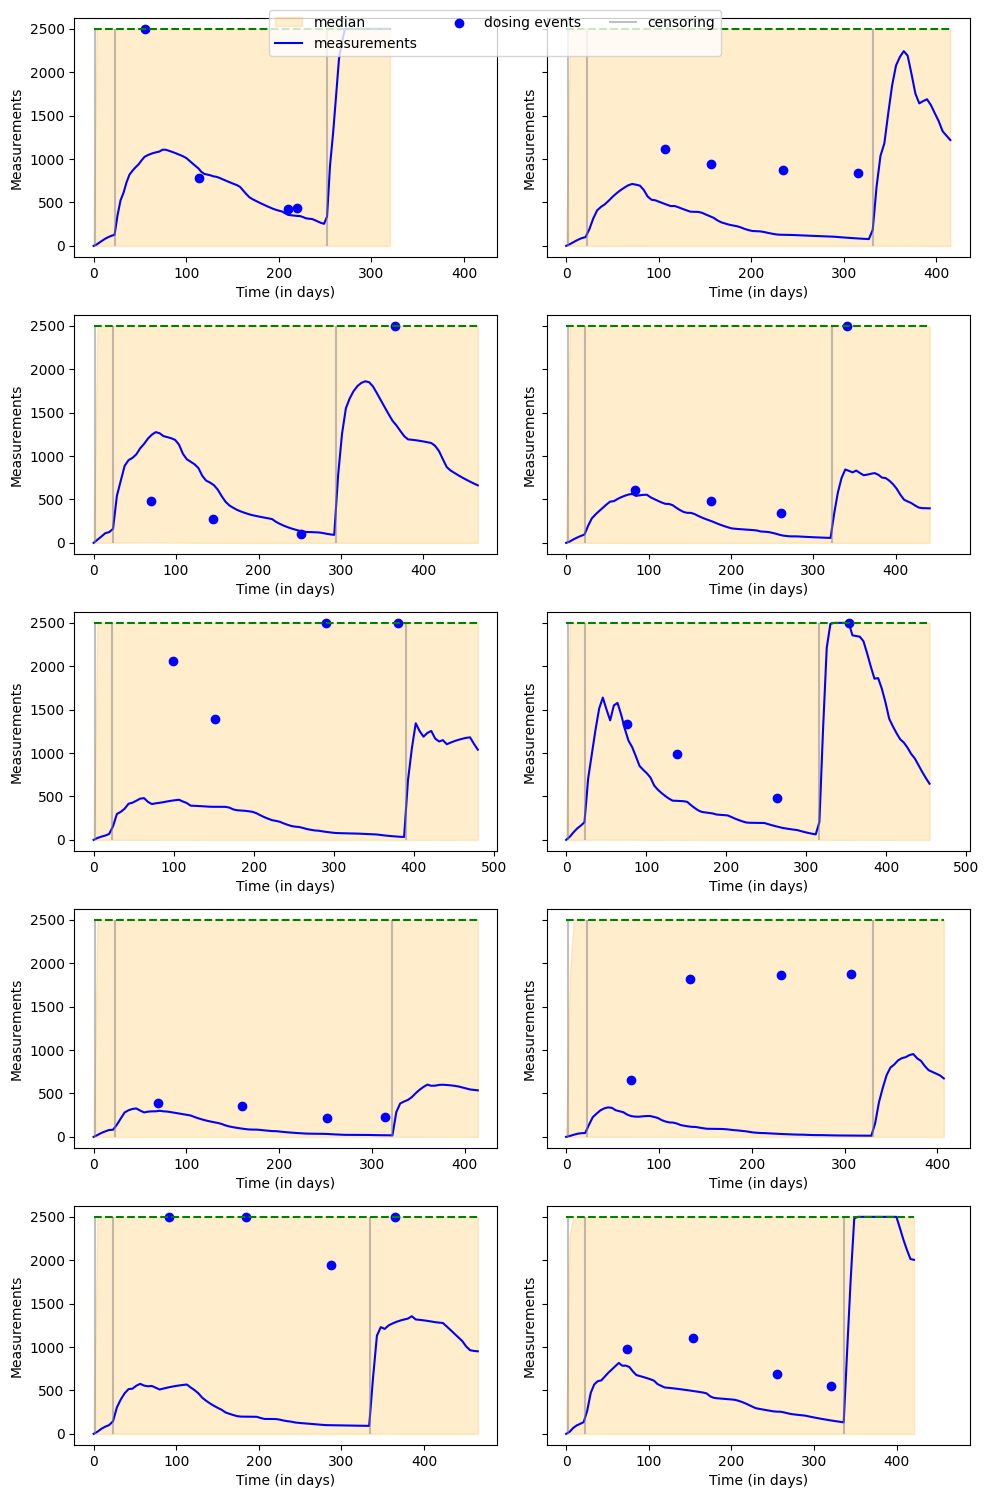

In [7]:
rows = 5
fig, ax = plt.subplots(rows, int(np.ceil(len(obs_data) / rows)), tight_layout=True, figsize=(10, rows*3),
                       sharex='row', sharey='all')
axis = ax.flatten()
    
for p_id in tqdm(range(len(obs_data))):
    axis[p_id] = model.prepare_plotting(obs_data[p_id], obs_data_posterior_samples[p_id], axis[p_id])
    _, labels = axis[p_id].get_legend_handles_labels()

fig.legend(labels, ncol=3, loc='upper center', bbox_to_anchor=(0.5, 1))
plt.show()

## Compare With MCMC Posterior

In [8]:
@njit
def log_likelihood_multiplicative_noise(log_measurements: np.ndarray, log_simulations: np.ndarray, 
                                        sigmas: Union[float, np.ndarray]) -> float:
    # compute the log-likelihood for multiplicative normal noise
    dif_sum = np.sum(((log_measurements - log_simulations) / sigmas)**2)
    if isinstance(sigmas, float):
        # needed for njit, cannot sum over float
        log_det_sigma = np.log(sigmas**2)
    else:
        log_det_sigma = np.sum(np.log(sigmas**2))
    # log_measurement.size = n_measurements + n_observables, len(log_measurement) = n_measurements
    llh = -0.5 * log_measurements.size * np.log(2 * np.pi) - 0.5*len(log_measurements)*log_det_sigma - np.log(log_measurements).sum() - 0.5 * dif_sum
    return llh

@njit
def log_likelihood_additive_noise(measurements: np.ndarray, simulations: np.ndarray, 
                                  sigmas: Union[float, np.ndarray]) -> float:
    # compute the log-likelihood for additive normal noise, proportionality might be captured in sigma already
    dif_sum = np.sum(((measurements - simulations) / sigmas)**2)
    log_det_sigma = np.sum(np.log(sigmas**2))
    llh = -0.5 * measurements.size * np.log(2 * np.pi) - 0.5*len(measurements)*log_det_sigma  - 0.5 * dif_sum
    return llh

In [9]:
@njit
def log_gaussian_prior_density(log_param: np.ndarray, mean: np.ndarray, 
                               inv_cov_matrix: np.ndarray, log_prior_constant: float) -> float:
    # compute the gaussian density of the prior
    dif = log_param - mean
    return log_prior_constant -0.5 * dif.dot(inv_cov_matrix).dot(dif.T)

if model.prior_type == 'uniform':
    log_uniform_prior_density = -np.log(np.diff(model.prior_bounds).prod())

In [10]:
individual_id = 0
obs_data_indv = obs_data[individual_id]

In [11]:
# prepare simulator accordingly to the model
if 'Froehlich' in model.name :
    # prepare simulator, data should be on log-scale
    simulator = partial(batch_simulator, 
                                n_obs=180,
                                with_noise=False)
    noise_model = 'multiplicative'  # additive on log-scale 
    index_sigma = -1  # index of sigma in parameter vector
    obs_data_indv_prepared = obs_data_indv.flatten()  # just one measurement per time point, already on log-scale
elif 'Pharma' in model.name:
    # prepare simulator, data should be on log-scale
    obs_data_indv_prepared, t_measurement, doses_time_points, dos, wt = convert_bf_to_observables(obs_data_indv)
    simulator = partial(batch_simulator,
                       t_measurement=t_measurement,
                       t_doses=doses_time_points,
                       wt=wt,
                       dos=dos,
                       with_noise=False,
                       convert_to_bf_batch=False)
    noise_model = 'multiplicative'  # additive on log-scale
    index_sigma = [-3, -2]  # index of sigmas in parameter vector
elif 'Clairon' in model.name:
    # prepare simulator, data should be on linear scale
    obs_data_indv_prepared, t_measurements, dose_amount, doses_time_points = convert_bf_to_observables(obs_data_indv)
    simulator = partial(batch_simulator,
                        t_measurements=t_measurements,
                        t_doses=doses_time_points,
                        with_noise=False,
                        convert_to_bf_batch=False)    
    noise_model = 'proportional'   # additive on linear scale
    index_sigma = [-2, -1]  # index of a, b in parameter vector of y+(a+by)*e
else:
    raise NotImplementedError('model not implemented')

assert simulator(model.prior_mean).shape == obs_data_indv_prepared.shape, 'simulator output shape does not match data shape' 

In [15]:
log_prior_constant = -0.5 * model.n_params * np.log(2 * np.pi) -0.5* np.linalg.slogdet(model.prior_cov).logabsdet
inv_cov = np.linalg.inv(model.prior_cov)

def neg_log_prop_posterior(log_param: np.ndarray):
    y_sim = simulator(log_param)  
    if noise_model == 'multiplicative':
        llh = log_likelihood_multiplicative_noise(log_measurements=obs_data_indv_prepared,
                                                  log_simulations=y_sim,
                                                  sigmas=np.exp(log_param[index_sigma]))
    else:  # noise_model == 'proportional':
        prop_sigma =  np.exp(log_param[index_sigma[0]]) + obs_data_indv_prepared * np.exp(log_param[index_sigma[1]])
        llh = log_likelihood_additive_noise(measurements=obs_data_indv_prepared,
                                            simulations=y_sim,
                                            sigmas=prop_sigma)
        
    if model.prior_type == 'normal':
        log_prior = log_gaussian_prior_density(log_param=log_param, mean=model.prior_mean, inv_cov_matrix=inv_cov,
                                               log_prior_constant=log_prior_constant)
    else:
        log_prior = log_uniform_prior_density
    return -(llh + log_prior)

In [16]:
neg_log_prop_posterior(model.prior_mean)

135.5839041026178

In [14]:
n_chains = 10
n_samples = 1e6
filename = f'output/mcmc_{model.name}_individual_{individual_id}.hdf5'

# create objective function
pesto_objective = FD(obj=Objective(fun=neg_log_prop_posterior),
                     x_names=model.log_param_names)

lb = model.prior_mean - 5 * model.prior_std
ub = model.prior_mean + 5 * model.prior_std

# create pypesto problem
pesto_problem = Problem(objective=pesto_objective,
                        lb=lb, ub=ub,
                        x_names=model.log_param_names,
                        x_scales=['log']*len(model.log_param_names))
pesto_problem.print_parameter_summary()

                       free    lb_full    ub_full
$\log$ fM2             True -10.861154  13.633743
$\log$ fM3             True  -9.762542  14.732355
$\log$ theta           True  -9.357077  15.137820
$\log$ deltaV          True -11.148836  13.346061
$\log$ deltaS          True -16.852619   7.642279
$\log$ error_constant  True -14.550034   9.944864
$\log$ error_prop      True -14.550034   9.944864


In [ ]:
# TODO: load from file if already exists

In [ ]:
result = optimize.minimize(problem=pesto_problem,
                           optimizer=optimize.ScipyOptimizer(),
                           n_starts=n_chains*10)

In [ ]:
visualize.parameters(result)
visualize.waterfall(result)
print(neg_log_prop_posterior(result.optimize_result.x[0]))

In [ ]:
fig, ax = plt.subplots(2, 3, tight_layout=True, figsize=(10, 5),
                       sharex='row', sharey='all')
axis = ax.flatten()
    
for p_id in tqdm(range(axis.size)):
    axis[p_id] = model.prepare_plotting(obs_data_indv, result.optimize_result.x[p_id], axis[p_id])
    _, labels = axis[p_id].get_legend_handles_labels()

fig.legend(labels, ncol=3, loc='upper center', bbox_to_anchor=(0.5, 1))
axis[0].set_title(f'best {axis.size} fits')
plt.show()

In [ ]:
sampler = sample.AdaptiveParallelTemperingSampler(
    internal_sampler=sample.AdaptiveMetropolisSampler(), n_chains=n_chains,
)

In [ ]:
result = sample.sample(
        pesto_problem, n_samples=n_samples, sampler=sampler,
        x0=list(result.optimize_result.x)[:n_chains],
        result=result)

In [ ]:
geweke_test = sample.geweke_test(result)
print('geweke_test', geweke_test)

auto_correlation = sample.auto_correlation(result)
print('auto_correlation', auto_correlation)

effective_sample_size = sample.effective_sample_size(result)
print('effective_sample_size', effective_sample_size)

In [ ]:
ax = visualize.sampling_parameter_traces(result, use_problem_bounds=True)

In [ ]:
visualize.sampling_fval_traces(result);

In [ ]:
store.write_result(
        result=result,
        filename=filename,
        problem=True,
        optimize=True,
        sample=True,
)

In [ ]:
pesto_samples = result.sample_result.trace_x[0]
print(pesto_samples.shape)

In [ ]:
burn_in = result.sample_result.burn_in
pesto_samples_adjusted = pesto_samples[burn_in:, :]
thinned_samples = pesto_samples_adjusted[::int(auto_correlation), :]
print(pesto_samples_adjusted.shape)
print(thinned_samples.shape)

In [ ]:
MAP_idx = np.argmin(result.sample_result.trace_neglogpost[0,burn_in:])
MAP = result.sample_result.trace_x[0,burn_in+MAP_idx,:]
print('MAP (sampling)', neg_log_prop_posterior(MAP))
print('MAP (optimizing)', neg_log_prop_posterior(result.optimize_result.x[0]))

if model_name == 'fröhlich-simple':
    # it is known, that this model's posterior should have two modes (in the first two parameters)
    other_MAP = MAP.copy()
    other_MAP[[0,1]] = other_MAP[[1,0]]
    print('MAP-2 (sampling)', neg_log_prop_posterior(other_MAP))

In [ ]:
fig, ax = plt.subplots(1, 1, tight_layout=True, figsize=(10, 5))

ax = model.prepare_plotting(obs_data_indv, MAP, ax)
_, labels = ax.get_legend_handles_labels()
fig.legend(labels, ncol=4, loc='lower center', bbox_to_anchor=(0.5, 1))

ax.set_title(f'MAP fit')
plt.show()

# Plot Posterior Histograms

In [ ]:
posterior_draws = model.draw_posterior_samples(data=obs_data_indv, n_samples=n_bayesflow_samples)

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=int(np.ceil(model.n_params/2)), tight_layout=True, figsize=(16,6))
axis = ax.flatten()

bins = 40
for i, name in enumerate(model.param_names):
    axis[i].set_title('log '+name)
    axis[i].hist(posterior_draws[:,i], bins=bins, density=True, label='BayesFlow', color='blue')

    axis[i].hist(thinned_samples[:,i], bins=bins, density=True, label='MCMC', alpha=0.6, color='red')
    axis[i].legend()

for _ax in fig.axes.flatten()[model.n_params:]:
    _ax.remove()
plt.show()

fig, ax = plt.subplots(nrows=2, ncols=int(np.ceil(model.n_params/2)), tight_layout=True, figsize=(16,6))
axis = ax.flatten()

bins = 40
for i, name in enumerate(model.param_names):
    axis[i].set_title(name)
    axis[i].hist(np.exp(posterior_draws[:,i]), bins=bins, density=True, label='BayesFlow', color='blue')

    axis[i].hist(np.exp(thinned_samples[:,i]), bins=bins, density=True, label='MCMC', alpha=0.6, color='red')
    axis[i].legend()

for _ax in fig.axes.flatten()[model.n_params:]:
    _ax.remove()
plt.show()

In [ ]:
fig, ax = plt.subplots(1, 2, tight_layout=True, figsize=(10, 5),
                       sharex='row', sharey='all')
    
ax[0] = model.prepare_plotting(obs_data_indv, posterior_draws, ax[0])
ax[1] = model.prepare_plotting(obs_data_indv, thinned_samples, ax[1])
_, labels = ax[0].get_legend_handles_labels()

fig.legend(labels, ncol=3, loc='lower center', bbox_to_anchor=(0.5, 1))
ax[0].set_title(f'Individual {individual_id}, BayesFlow')
ax[1].set_title(f'Individual {individual_id}, MCMC')
plt.show()

# Dimensionality Reduction

In [ ]:
import umap
from sklearn.preprocessing import StandardScaler

In [ ]:
all_samples = np.concatenate((posterior_draws, thinned_samples), axis=0)
#all_samples = np.concatenate((posterior_draws, pesto_samples_adjusted), axis=0)
#all_samples = np.concatenate((posterior_draws, thinned_samples), axis=0)
scaled_samples = StandardScaler().fit_transform(all_samples)

reducer = umap.UMAP()
embedding = reducer.fit_transform(scaled_samples)
plt.scatter(
    embedding[:posterior_draws.shape[0], 0],
    embedding[:posterior_draws.shape[0], 1], label='BayesFlow', alpha=0.5, color='blue')
plt.scatter(
    embedding[thinned_samples.shape[0]:, 0],
    embedding[thinned_samples.shape[0]:, 1], label='MCMC', alpha=0.5, color='red')
plt.legend()

plt.show()